 ### conda install python-slugify 
 ### conda install kaggle
 ### conda install scikit-learn
 

In [ ]:
!kaggle datasets download -d fatihkgg/affectnet-yolo-format


## Unzip the compressed file that was downloaded in your directory

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import os
import glob
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from timeit import default_timer as timer
from pathlib import Path
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
num_classes = 8 
num_epochs = 15
batch_size = 64
lr = 0.001
num_epochs_25 = 25
class_names = ["Anger", "Contempt", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"] # 0-Anger, 1-Contempt, 2-Disgust, 3-Fear, 4-Happy, 5-Neutral, 6-Sad, 7-Surprise

In [8]:
# Function that prints execution time
def train_time(start: float, end: float, device: torch.device = None):
    total_time = end - start;
    print(f"Execution Time on {device}: {total_time:.4f} seconds")


# Function that trains the model, prints validation and training loss and accuracy, execution time and outputs loss and accuracies
def train_model(
    model, 
    num_epochs, 
    optimizer, 
    criterion, 
    train_loader, 
    valid_loader
):
    """
    Trains and validates a PyTorch model.

    Parameters:
        model (torch.nn.Module): The PyTorch model to be trained.
        num_epochs (int): Number of epochs for training.
        optimizer (torch.optim.Optimizer): Optimizer used for training.
        criterion (torch.nn.Module): Loss function.
        train_loader (torch.utils.data.DataLoader): DataLoader for training data.
        valid_loader (torch.utils.data.DataLoader): DataLoader for validation data.

    Returns:
        tuple: (train_loss_per_epoch, valid_loss_per_epoch, train_acc_per_epoch, valid_acc_per_epoch)
    """
    # Set device to GPU if available, otherwise use CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Arrays to track metrics per epoch
    train_loss_per_epoch = []
    valid_loss_per_epoch = []
    train_acc_per_epoch = []
    valid_acc_per_epoch = []

    train_start = timer()

    # Training loop
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        train_loss = 0.0
        correct_train, total_train = 0, 0

        for batch_images, batch_labels in train_loader:
            # Move images and labels to device (GPU or CPU)
            batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs_train = model(batch_images)
            _, predicted_train = torch.max(outputs_train, 1)
            total_train += batch_labels.size(0)
            correct_train += (predicted_train == batch_labels).sum().item()

            # Compute and accumulate loss
            loss = criterion(outputs_train, batch_labels)
            train_loss += loss.item()

            # Backward pass and optimizer step
            loss.backward()
            optimizer.step()

        valid_loss = 0.0
        correct_valid, total_valid = 0, 0
        model.eval()

        # Validation loop
        with torch.inference_mode():
            for batch_images, batch_labels in valid_loader:
                batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)

                # Forward pass
                outputs_valid = model(batch_images)
                _, predicted_valid = torch.max(outputs_valid, 1)
                total_valid += batch_labels.size(0)
                correct_valid += (predicted_valid == batch_labels).sum().item()

                # Compute and accumulate loss
                loss = criterion(outputs_valid, batch_labels)
                valid_loss += loss.item()

        # Compute average losses and accuracies
        train_loss /= len(train_loader)
        valid_loss /= len(valid_loader)
        train_accuracy = 100 * correct_train / total_train
        valid_accuracy = 100 * correct_valid / total_valid

        # Append metrics for this epoch
        train_loss_per_epoch.append(train_loss)
        valid_loss_per_epoch.append(valid_loss)
        train_acc_per_epoch.append(train_accuracy)
        valid_acc_per_epoch.append(valid_accuracy)

        # Print epoch stats
        print(
            f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, "
            f"Train Accuracy: {train_accuracy:.2f}% | Valid Loss: {valid_loss:.4f}, "
            f"Valid Accuracy: {valid_accuracy:.2f}%"
        )

    train_end = timer()
    print(f"Training completed in {train_end - train_start:.2f} seconds on {device}.")
    
    return train_loss_per_epoch, valid_loss_per_epoch, train_acc_per_epoch, valid_acc_per_epoch


In [10]:
def test_model(
    model,
    criterion,
    test_loader
):

    # Set device to GPU if available, otherwise use CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    test_loss = 0.0
    correct_test, total_test = 0, 0
    model.eval()
    
    with torch.inference_mode():
        for batch_images, batch_labels in test_loader:
            batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)
    
            # Forward pass
            outputs_test = model(batch_images)
            _, predicted_test = torch.max(outputs_test, 1)
            total_test += batch_labels.size(0)
            correct_test += (predicted_test == batch_labels).sum().item()
    
            # Compute and accumulate loss
            loss = criterion(outputs_test, batch_labels)
            test_loss += loss.item()
    
    # Compute average losses and accuracies
    test_loss /= len(test_loader)
    test_accuracy = 100 * correct_test / total_test
    
    
    
    # Print  stats
    print(
        f"Test Loss: {test_loss:.4f}, "
        f"Test Accuracy: {test_accuracy:.2f}%"
    )

In [12]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        """
        Initialize the EarlyStopping object.
        Args:
        - patience (int): Number of epochs to wait for an improvement.
        - min_delta (float): Minimum change in validation accuracy to qualify as an improvement.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_acc = -np.inf
        self.early_stop = False

    def __call__(self, val_acc):
        # Check for improvement
        if val_acc > self.best_acc + self.min_delta:
            self.best_acc = val_acc
            self.counter = 0  # Reset the patience counter
        else:
            self.counter += 1  # No improvement
            if self.counter >= self.patience:
                self.early_stop = True


# Image Preprocessing

In [15]:
# Define paths
# change path to the relevant directory
train_images_path = "C:/Users/alexk/Python/ML/affectnet-yolo-format/YOLO_format/train/images"
train_labels_path = "C:/Users/alexk/Python/ML/affectnet-yolo-format/YOLO_format/train/labels"
valid_images_path = "C:/Users/alexk/Python/ML/affectnet-yolo-format/YOLO_format/valid/images"
valid_labels_path = "C:/Users/alexk/Python/ML/affectnet-yolo-format/YOLO_format/valid/labels"
test_images_path = "C:/Users/alexk/Python/ML/affectnet-yolo-format/YOLO_format/test/images"
test_labels_path = "C:/Users/alexk/Python/ML/affectnet-yolo-format/YOLO_format/test/labels"

# Get image and label files from directory
train_image_files = sorted(glob.glob(os.path.join(train_images_path, "*.png")) + glob.glob(os.path.join(train_images_path, "*.jpg")))
train_label_files = sorted(glob.glob(os.path.join(train_labels_path, "*.txt")))
valid_image_files = sorted(glob.glob(os.path.join(valid_images_path, "*.png")) + glob.glob(os.path.join(valid_images_path, "*.jpg")))
valid_label_files = sorted(glob.glob(os.path.join(valid_labels_path, "*.txt")))
test_image_files = sorted(glob.glob(os.path.join(test_images_path, "*.png")) + glob.glob(os.path.join(test_images_path, "*.jpg")))
test_label_files = sorted(glob.glob(os.path.join(test_labels_path, "*.txt")))

# Read class_id (from label txt)
def load_labels(label_file):
  with open(label_file, 'r') as f:
    train_label = f.readlines()
    class_id = int(train_label[0].split()[0])   # Extract the class_id (first element)
    return class_id

# Map image paths to class labels
train_image_paths = train_image_files
train_class_labels = []
valid_image_paths = valid_image_files
valid_class_labels = []
test_image_paths = test_image_files
test_class_labels = []

# Training labels list
for label_file in train_label_files:
  label = load_labels(label_file)
  train_class_labels.append(label)

# Validation labels list
for label_file in valid_label_files:
  label = load_labels(label_file)
  valid_class_labels.append(label)

# Testing labels list
for label_file in test_label_files:
  label = load_labels(label_file)
  test_class_labels.append(label)


In [16]:
# Function to load and preprocess images
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")  # Open image
    image = transform(image)  # Apply transformations
    return image

class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = preprocess_image(self.image_paths[idx])
        label = self.labels[idx]
        return image, label

# Neural Network #1
LLM generated as a baseline model

In [208]:
class FirstCNN(nn.Module):
    def __init__(self, num_classes):  # Modify num_classes based on your dataset
        super(FirstCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)

        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 12 * 12, 256)  # 128 feature maps of size 12x12
        self.fc2 = nn.Linear(256, num_classes)  # Final layer outputs 'num_classes'

    def forward(self, x):
        # Pass through conv layers + ReLU + pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # Flatten the output for fully connected layers
        x = x.view(-1, 128 * 12 * 12)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x


# 1st Model

In [211]:
# Initial Preprocessing, NO Normalization
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to PyTorch Tensor
])

# Create dataset objects
train_dataset = CustomDataset(train_image_paths, train_class_labels, transform=transform)
valid_dataset = CustomDataset(valid_image_paths, valid_class_labels, transform=transform)

# DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)


In [213]:
# Initialize the model
torch.manual_seed(42)
modelV1 = FirstCNN(num_classes=num_classes)

# Use Cross-Entropy Loss for classification
criterion = nn.CrossEntropyLoss()

# Adam optimizer
optimizer = optim.Adam(modelV1.parameters(), lr=lr)

In [215]:
train_loss = []
valid_loss = []
train_acc = []
valid_acc = []

In [ ]:
train_loss, valid_loss, train_acc, valid_acc = train_model(modelV1, num_epochs, optimizer, criterion, train_loader, valid_loader) # Execution Time: 489 seconds

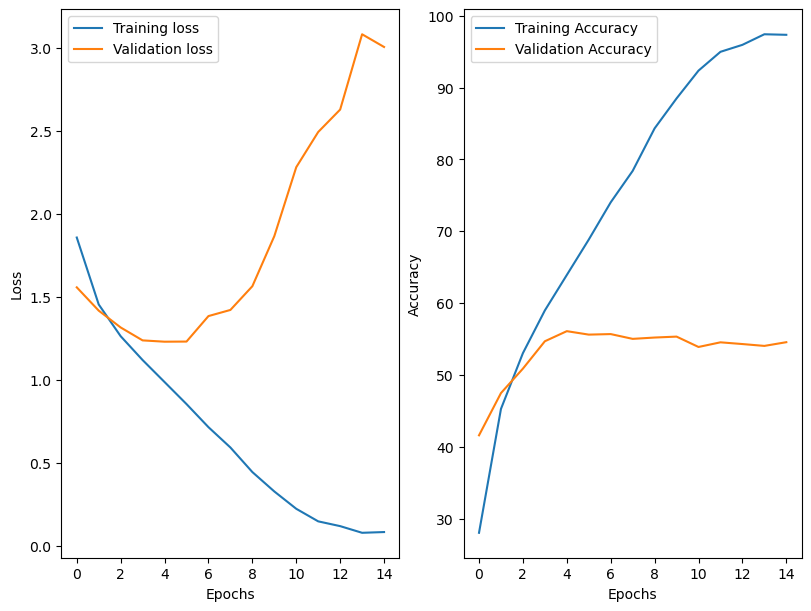

In [54]:
fig, V1 = plt.subplots(1, 2, figsize=(8, 6), layout='constrained')

V1[0].plot(range(num_epochs), train_loss, label='Training loss')
V1[0].plot(range(num_epochs), valid_loss, label='Validation loss')
V1[0].set_xlabel('Epochs')
V1[0].set_ylabel('Loss')
V1[0].legend()
V1[1].plot(range(num_epochs), train_acc, label='Training Accuracy');
V1[1].plot(range(num_epochs), valid_acc, label='Validation Accuracy');
V1[1].set_xlabel('Epochs')
V1[1].set_ylabel('Accuracy')
V1[1].legend()
fig.savefig('V1_Initial.png')

### Seems like the model is overfitting...
Validation loss is minimized at epoch 6

# 2nd Model
Given info that normalization affects overall accuracy, it was tested to confirm 

In [21]:
# Initial Preprocessing, WITH Normalization
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to PyTorch Tensor, scales [0,255] to [0,1]
    transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)) # Normalize data to [-1,1]
])

# Create dataset objects
train_dataset = CustomDataset(train_image_paths, train_class_labels, transform=transform)
valid_dataset = CustomDataset(valid_image_paths, valid_class_labels, transform=transform)

# DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

In [59]:
# Initialize the model
torch.manual_seed(42)
modelV2 = FirstCNN(num_classes=num_classes)

# Use Cross-Entropy Loss for classification
criterion = nn.CrossEntropyLoss()

# Adam optimizer
optimizer = optim.Adam(modelV2.parameters(), lr=lr)

In [61]:
train_loss = []
valid_loss = []
train_acc = []
valid_acc = []

train_loss, valid_loss, train_acc, valid_acc = train_model(modelV2, num_epochs, optimizer, criterion, train_loader, valid_loader) # Execution Time: 485 seconds

Epoch [1/15], Train Loss: 1.7750, Train Accuracy: 31.76% | Valid Loss: 1.4882, Valid Accuracy: 45.04%
Epoch [2/15], Train Loss: 1.3909, Train Accuracy: 48.24% | Valid Loss: 1.3714, Valid Accuracy: 49.19%
Epoch [3/15], Train Loss: 1.1720, Train Accuracy: 56.82% | Valid Loss: 1.2769, Valid Accuracy: 53.31%
Epoch [4/15], Train Loss: 0.9821, Train Accuracy: 64.25% | Valid Loss: 1.2313, Valid Accuracy: 55.70%
Epoch [5/15], Train Loss: 0.8009, Train Accuracy: 70.70% | Valid Loss: 1.3221, Valid Accuracy: 55.66%
Epoch [6/15], Train Loss: 0.6022, Train Accuracy: 78.54% | Valid Loss: 1.4072, Valid Accuracy: 55.25%
Epoch [7/15], Train Loss: 0.4188, Train Accuracy: 85.45% | Valid Loss: 1.6586, Valid Accuracy: 55.44%
Epoch [8/15], Train Loss: 0.2540, Train Accuracy: 91.21% | Valid Loss: 1.9651, Valid Accuracy: 54.31%
Epoch [9/15], Train Loss: 0.1675, Train Accuracy: 94.40% | Valid Loss: 2.4347, Valid Accuracy: 54.92%
Epoch [10/15], Train Loss: 0.1037, Train Accuracy: 96.49% | Valid Loss: 2.6930, Va

Didn't help? Needs further testing

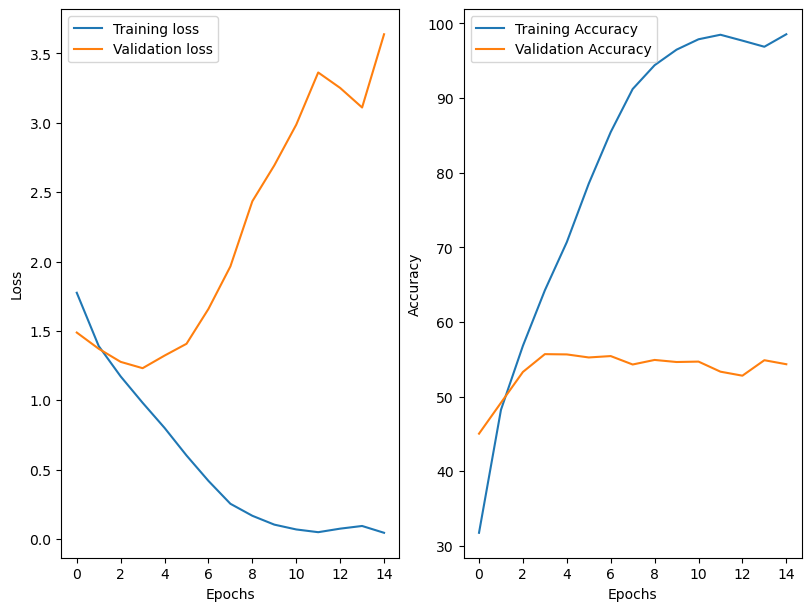

In [66]:
fig, V2 = plt.subplots(1, 2, figsize=(8, 6), layout='constrained')

V2[0].plot(range(num_epochs), train_loss, label='Training loss')
V2[0].plot(range(num_epochs), valid_loss, label='Validation loss')
V2[0].set_xlabel('Epochs')
V2[0].set_ylabel('Loss')
V2[0].legend()
V2[1].plot(range(num_epochs), train_acc, label='Training Accuracy');
V2[1].plot(range(num_epochs), valid_acc, label='Validation Accuracy');
V2[1].set_xlabel('Epochs')
V2[1].set_ylabel('Accuracy')
V2[1].legend()
fig.savefig('V2_with_normalization.png')

# Neural Network #2

In [69]:
class CNN_Dropout_Linear(nn.Module):
    def __init__(self, num_classes):  # Modify num_classes based on your dataset
        super(CNN_Dropout_Linear, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)

        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 12 * 12, 256)  # 128 feature maps of size 12x12
        self.fc2 = nn.Linear(256, num_classes)  # Final layer outputs 'num_classes'

        # Dropout layer
        self.dropout = nn.Dropout(p=0.5) # Dropout of 50% ( Only between fully connected layers)

    def forward(self, x):
        # Pass through conv layers + ReLU + pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # Flatten the output for fully connected layers
        x = x.view(-1, 128 * 12 * 12)

        # Fully connected layers (with dropout)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x


# 3rd model
Validation loss starts to stagnate at around 10 epochs and remains at roughly 54%, will try dropout to get out of local minima
##### https://arxiv.org/pdf/1207.0580
### Noted: 
#### p =0.2-0.3 for convolution layers (after pooling)
#### p =0.5 between fully connected (Linear)
Will try 2nd option, between Fully connected inner layers

In [116]:
# Initial Preprocessing, NO Normalization
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to PyTorch Tensor, scales [0,255] to [0,1]
])

# Create dataset objects
train_dataset = CustomDataset(train_image_paths, train_class_labels, transform=transform)
valid_dataset = CustomDataset(valid_image_paths, valid_class_labels, transform=transform)

# DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

In [150]:

# Initialize the model
torch.manual_seed(42)
modelV3 = CNN_Dropout_Linear(num_classes=num_classes)

# Use Cross-Entropy Loss for classification
criterion = nn.CrossEntropyLoss()

# Adam optimizer
optimizer = optim.Adam(modelV3.parameters(), lr=lr)

In [120]:
train_loss = []
valid_loss = []
train_acc = []
valid_acc = []

train_loss, valid_loss, train_acc, valid_acc = train_model(modelV3, num_epochs_25, optimizer, criterion, train_loader, valid_loader) # Execution Time: 495 seconds

Epoch [1/25], Train Loss: 1.9496, Train Accuracy: 23.86% | Valid Loss: 1.6343, Valid Accuracy: 40.05%
Epoch [2/25], Train Loss: 1.5695, Train Accuracy: 40.86% | Valid Loss: 1.4196, Valid Accuracy: 46.74%
Epoch [3/25], Train Loss: 1.3961, Train Accuracy: 47.45% | Valid Loss: 1.3111, Valid Accuracy: 51.65%
Epoch [4/25], Train Loss: 1.2815, Train Accuracy: 51.90% | Valid Loss: 1.2500, Valid Accuracy: 53.16%
Epoch [5/25], Train Loss: 1.1604, Train Accuracy: 56.91% | Valid Loss: 1.2097, Valid Accuracy: 55.11%
Epoch [6/25], Train Loss: 1.0579, Train Accuracy: 60.46% | Valid Loss: 1.2118, Valid Accuracy: 55.83%
Epoch [7/25], Train Loss: 0.9618, Train Accuracy: 64.10% | Valid Loss: 1.1835, Valid Accuracy: 57.10%
Epoch [8/25], Train Loss: 0.8704, Train Accuracy: 66.97% | Valid Loss: 1.2101, Valid Accuracy: 57.31%
Epoch [9/25], Train Loss: 0.7784, Train Accuracy: 70.64% | Valid Loss: 1.2384, Valid Accuracy: 57.44%
Epoch [10/25], Train Loss: 0.6878, Train Accuracy: 74.41% | Valid Loss: 1.2600, Va

2.2% improvement over baseline model

It may help, should dropout after convolution layers too?

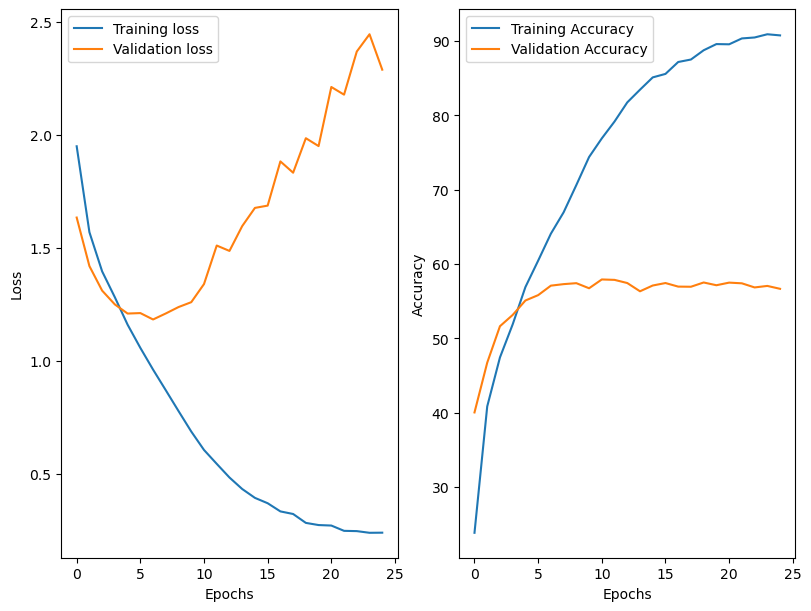

In [124]:
fig, V3 = plt.subplots(1, 2, figsize=(8, 6), layout='constrained')

V3[0].plot(range(num_epochs_25), train_loss, label='Training loss')
V3[0].plot(range(num_epochs_25), valid_loss, label='Validation loss')
V3[0].set_xlabel('Epochs')
V3[0].set_ylabel('Loss')
V3[0].legend()
V3[1].plot(range(num_epochs_25), train_acc, label='Training Accuracy');
V3[1].plot(range(num_epochs_25), valid_acc, label='Validation Accuracy');
V3[1].set_xlabel('Epochs')
V3[1].set_ylabel('Accuracy')
V3[1].legend()
fig.savefig('V3_Dropout_Linear_Layers.png')

# Neural Network #3

In [91]:
class CNN_Dropout_Full(nn.Module):
    def __init__(self, num_classes):  # Modify num_classes based on your dataset
        super(CNN_Dropout_Full, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)

        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 12 * 12, 256)  # 128 feature maps of size 12x12
        self.fc2 = nn.Linear(256, num_classes)  # Final layer outputs 'num_classes'

        # Dropout layer
        self.dropoutLin = nn.Dropout(p=0.5) # Dropout of 50% ( Only between fully connected layers)
        self.dropoutConv = nn.Dropout(p=0.3) # Dropout of 30% ( Only after convolutional layers)

    def forward(self, x):
        # Pass through conv layers + ReLU + pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropoutConv(x)

        # Flatten the output for fully connected layers
        x = x.view(-1, 128 * 12 * 12)

        # Fully connected layers (with dropout)
        x = F.relu(self.fc1(x))
        x = self.dropoutLin(x)
        x = self.fc2(x)

        return x


# 4th Model
Apply dropout to both Linear Layers and Convolutional Layers

In [94]:
# Initial Preprocessing, NO Normalization
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to PyTorch Tensor, scales [0,255] to [0,1]
])

# Create dataset objects
train_dataset = CustomDataset(train_image_paths, train_class_labels, transform=transform)
valid_dataset = CustomDataset(valid_image_paths, valid_class_labels, transform=transform)

# DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

In [96]:
# Initialize the model
torch.manual_seed(42)
modelV4 = CNN_Dropout_Full(num_classes=num_classes)

# Use Cross-Entropy Loss for classification
criterion = nn.CrossEntropyLoss()

# Adam optimizer
optimizer = optim.Adam(modelV4.parameters(), lr=lr)

In [98]:
train_loss = []
valid_loss = []
train_acc = []
valid_acc = []

train_loss, valid_loss, train_acc, valid_acc = train_model(modelV4, num_epochs_25, optimizer, criterion, train_loader, valid_loader) # Execution Time: 872 seconds

Epoch [1/25], Train Loss: 1.9689, Train Accuracy: 22.73% | Valid Loss: 1.7078, Valid Accuracy: 36.15%
Epoch [2/25], Train Loss: 1.6808, Train Accuracy: 36.58% | Valid Loss: 1.5083, Valid Accuracy: 43.82%
Epoch [3/25], Train Loss: 1.5460, Train Accuracy: 42.24% | Valid Loss: 1.4347, Valid Accuracy: 47.39%
Epoch [4/25], Train Loss: 1.4800, Train Accuracy: 44.82% | Valid Loss: 1.3794, Valid Accuracy: 48.96%
Epoch [5/25], Train Loss: 1.4046, Train Accuracy: 47.73% | Valid Loss: 1.3448, Valid Accuracy: 50.74%
Epoch [6/25], Train Loss: 1.3624, Train Accuracy: 49.16% | Valid Loss: 1.3126, Valid Accuracy: 52.13%
Epoch [7/25], Train Loss: 1.3304, Train Accuracy: 50.54% | Valid Loss: 1.2800, Valid Accuracy: 53.00%
Epoch [8/25], Train Loss: 1.2763, Train Accuracy: 52.33% | Valid Loss: 1.2637, Valid Accuracy: 52.90%
Epoch [9/25], Train Loss: 1.2511, Train Accuracy: 53.71% | Valid Loss: 1.2502, Valid Accuracy: 53.37%
Epoch [10/25], Train Loss: 1.2071, Train Accuracy: 55.23% | Valid Loss: 1.2274, Va

Worse than applying dropout at just Linear

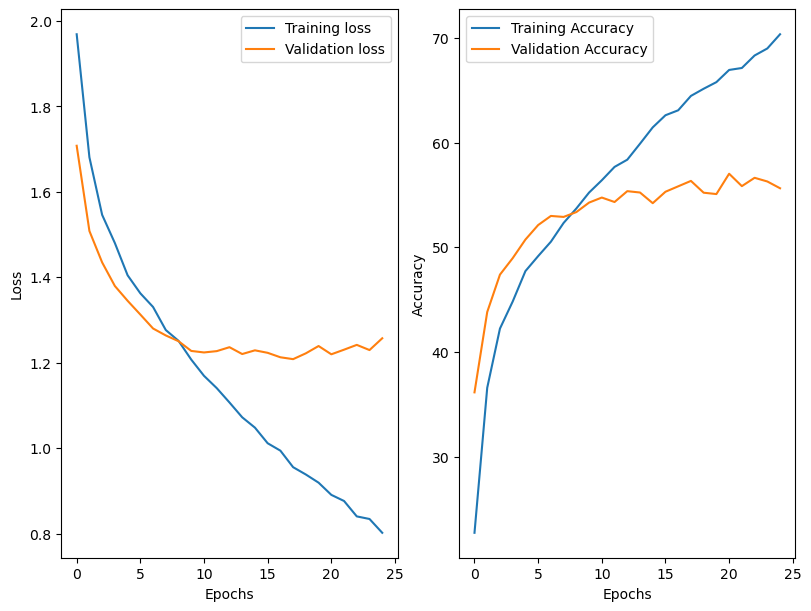

In [102]:
fig, V4 = plt.subplots(1, 2, figsize=(8, 6), layout='constrained')

V4[0].plot(range(num_epochs_25), train_loss, label='Training loss')
V4[0].plot(range(num_epochs_25), valid_loss, label='Validation loss')
V4[0].set_xlabel('Epochs')
V4[0].set_ylabel('Loss')
V4[0].legend() 
V4[1].plot(range(num_epochs_25), train_acc, label='Training Accuracy');
V4[1].plot(range(num_epochs_25), valid_acc, label='Validation Accuracy');
V4[1].set_xlabel('Epochs')
V4[1].set_ylabel('Accuracy')
V4[1].legend()
fig.savefig('V4_Dropout_All_Layers.png')

# 5th Model
Will try dropout with normalization. Will use CNN_Dropout_Linear from now on

In [104]:
# Initial Preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to PyTorch Tensor, scales [0,255] to [0,1]
    transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)) # Normalize data to [-1,1]
])

# Create dataset objects
train_dataset = CustomDataset(train_image_paths, train_class_labels, transform=transform)
valid_dataset = CustomDataset(valid_image_paths, valid_class_labels, transform=transform)

# DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

In [106]:
# Initialize the model
torch.manual_seed(42)
modelV5 = CNN_Dropout_Linear(num_classes=num_classes)

# Use Cross-Entropy Loss for classification
criterion = nn.CrossEntropyLoss()

# Adam optimizer
optimizer = optim.Adam(modelV5.parameters(), lr=lr)

In [108]:
train_loss = []
valid_loss = []
train_acc = []
valid_acc = []

train_loss, valid_loss, train_acc, valid_acc = train_model(modelV5, num_epochs_25, optimizer, criterion, train_loader, valid_loader) # Execution Time: 886 seconds

Epoch [1/25], Train Loss: 1.8044, Train Accuracy: 30.64% | Valid Loss: 1.4928, Valid Accuracy: 45.02%
Epoch [2/25], Train Loss: 1.4671, Train Accuracy: 44.87% | Valid Loss: 1.2986, Valid Accuracy: 51.59%
Epoch [3/25], Train Loss: 1.2721, Train Accuracy: 53.22% | Valid Loss: 1.2210, Valid Accuracy: 54.31%
Epoch [4/25], Train Loss: 1.1279, Train Accuracy: 57.73% | Valid Loss: 1.1752, Valid Accuracy: 56.68%
Epoch [5/25], Train Loss: 0.9857, Train Accuracy: 63.51% | Valid Loss: 1.1882, Valid Accuracy: 56.92%
Epoch [6/25], Train Loss: 0.8340, Train Accuracy: 68.90% | Valid Loss: 1.1813, Valid Accuracy: 57.45%
Epoch [7/25], Train Loss: 0.7180, Train Accuracy: 73.39% | Valid Loss: 1.2447, Valid Accuracy: 57.86%
Epoch [8/25], Train Loss: 0.5989, Train Accuracy: 78.07% | Valid Loss: 1.3003, Valid Accuracy: 57.90%
Epoch [9/25], Train Loss: 0.5123, Train Accuracy: 80.80% | Valid Loss: 1.3793, Valid Accuracy: 57.45%
Epoch [10/25], Train Loss: 0.4298, Train Accuracy: 83.97% | Valid Loss: 1.4898, Va

Slightly increases accuracy by 1% 

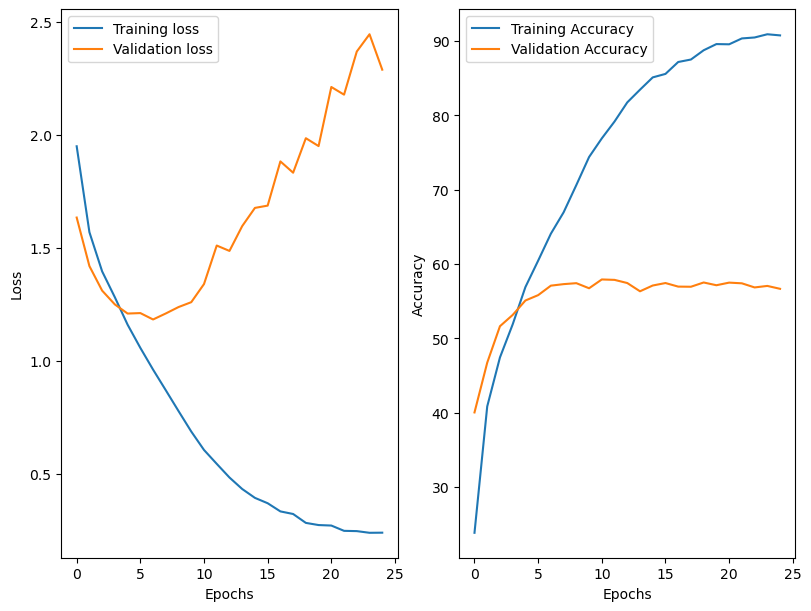

In [130]:
fig, V5 = plt.subplots(1, 2, figsize=(8, 6), layout='constrained')

V5[0].plot(range(num_epochs_25), train_loss, label='Training loss')
V5[0].plot(range(num_epochs_25), valid_loss, label='Validation loss')
V5[0].set_xlabel('Epochs')
V5[0].set_ylabel('Loss')
V5[0].legend() 
V5[1].plot(range(num_epochs_25), train_acc, label='Training Accuracy');
V5[1].plot(range(num_epochs_25), valid_acc, label='Validation Accuracy');
V5[1].set_xlabel('Epochs')
V5[1].set_ylabel('Accuracy')
V5[1].legend()
fig.savefig('V5_Dropout_Linear_Layer_with_Normalization.png')

# 6th Model
Linear dropout neural network and normalization. Addition of weight decay on the optimizer

In [21]:
# Initial Preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to PyTorch Tensor, scales [0,255] to [0,1]
    transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)) # Normalize data to [-1,1]
])

# Create dataset objects
train_dataset = CustomDataset(train_image_paths, train_class_labels, transform=transform)
valid_dataset = CustomDataset(valid_image_paths, valid_class_labels, transform=transform)

# DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

In [154]:
# Initialize the model
torch.manual_seed(42)
modelV6 = CNN_Dropout_Linear(num_classes=num_classes)

# Use Cross-Entropy Loss for classification
criterion = nn.CrossEntropyLoss()

# Only decay of weights, not bias
decay = []
no_decay = []
for name, param in modelV6.named_parameters():
    if "bias" in name:
        no_decay.append(param)
    else:
        decay.append(param)
# Adam optimizer
optimizer = optim.AdamW([
    {"params": decay, "weight_decay": 1e-4},
    {"params": no_decay, "weight_decay": 0.0},
], lr=lr)

In [156]:
train_loss = []
valid_loss = []
train_acc = []
valid_acc = []

train_loss, valid_loss, train_acc, valid_acc = train_model(modelV6, num_epochs_25, optimizer, criterion, train_loader, valid_loader) # Execution Time: 872 seconds

Epoch [1/25], Train Loss: 1.8179, Train Accuracy: 29.76% | Valid Loss: 1.5264, Valid Accuracy: 43.10%
Epoch [2/25], Train Loss: 1.4903, Train Accuracy: 43.44% | Valid Loss: 1.3325, Valid Accuracy: 50.94%
Epoch [3/25], Train Loss: 1.3082, Train Accuracy: 51.24% | Valid Loss: 1.2326, Valid Accuracy: 54.29%
Epoch [4/25], Train Loss: 1.1650, Train Accuracy: 56.62% | Valid Loss: 1.1969, Valid Accuracy: 56.81%
Epoch [5/25], Train Loss: 1.0298, Train Accuracy: 61.66% | Valid Loss: 1.1717, Valid Accuracy: 57.31%
Epoch [6/25], Train Loss: 0.9099, Train Accuracy: 66.12% | Valid Loss: 1.1570, Valid Accuracy: 57.58%
Epoch [7/25], Train Loss: 0.7973, Train Accuracy: 70.46% | Valid Loss: 1.2104, Valid Accuracy: 57.75%
Epoch [8/25], Train Loss: 0.6780, Train Accuracy: 75.00% | Valid Loss: 1.2659, Valid Accuracy: 57.47%
Epoch [9/25], Train Loss: 0.5835, Train Accuracy: 78.36% | Valid Loss: 1.3267, Valid Accuracy: 57.14%
Epoch [10/25], Train Loss: 0.5010, Train Accuracy: 81.01% | Valid Loss: 1.4827, Va

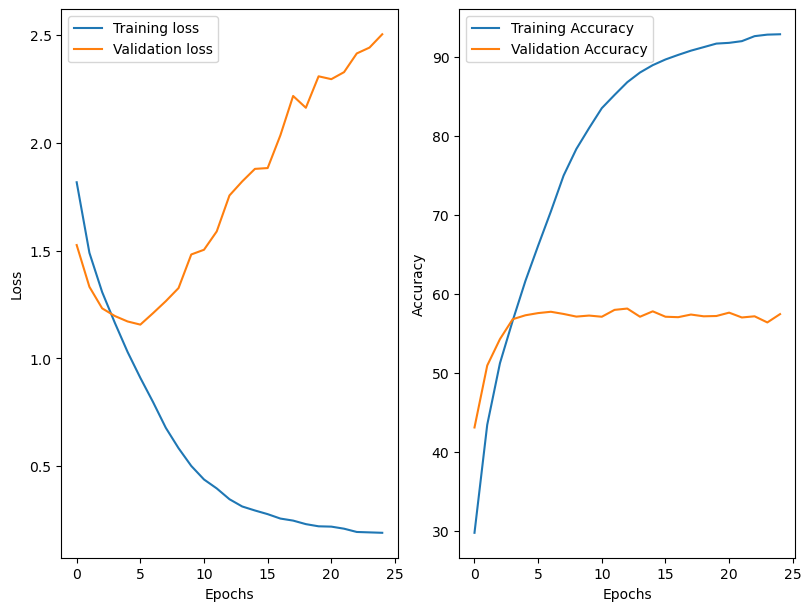

In [161]:
fig, V6 = plt.subplots(1, 2, figsize=(8, 6), layout='constrained')

V6[0].plot(range(num_epochs_25), train_loss, label='Training loss')
V6[0].plot(range(num_epochs_25), valid_loss, label='Validation loss')
V6[0].set_xlabel('Epochs')
V6[0].set_ylabel('Loss')
V6[0].legend() 
V6[1].plot(range(num_epochs_25), train_acc, label='Training Accuracy');
V6[1].plot(range(num_epochs_25), valid_acc, label='Validation Accuracy');
V6[1].set_xlabel('Epochs')
V6[1].set_ylabel('Accuracy')
V6[1].legend()
fig.savefig('V6_Dropout_Linear_Layer_with_Normalization_Weight_decay.png')

Accuracy doesn't change much. Will attempt to increase weight decay 

# 7th Model
further increase of weight decay (10**-4 --> 10**-3)

In [18]:
# Initial Preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to PyTorch Tensor, scales [0,255] to [0,1]
    transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)) # Normalize data to [-1,1]
])

# Create dataset objects
train_dataset = CustomDataset(train_image_paths, train_class_labels, transform=transform)
valid_dataset = CustomDataset(valid_image_paths, valid_class_labels, transform=transform)

# DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

In [269]:
# Initialize model
torch.manual_seed(42)
modelV7 = CNN_Dropout_Linear(num_classes=num_classes)

# Use Cross-Entropy Loss for classification
criterion = nn.CrossEntropyLoss()

# Only decay of weights, not bias
decay = []
no_decay = []
for name, param in modelV7.named_parameters():
    if "bias" in name:
        no_decay.append(param)
    else:
        decay.append(param)
# Adam optimizer
optimizer = optim.AdamW([
    {"params": decay, "weight_decay": 1e-3},
    {"params": no_decay, "weight_decay": 0.0},
], lr=lr)


In [271]:
train_loss = []
valid_loss = []
train_acc = []
valid_acc = []

train_loss, valid_loss, train_acc, valid_acc = train_model(modelV7, num_epochs_25, optimizer, criterion, train_loader, valid_loader) # Execution Time: 969 seconds

Epoch [1/25], Train Loss: 1.8049, Train Accuracy: 30.63% | Valid Loss: 1.5278, Valid Accuracy: 43.67%
Epoch [2/25], Train Loss: 1.4747, Train Accuracy: 44.80% | Valid Loss: 1.3198, Valid Accuracy: 50.81%
Epoch [3/25], Train Loss: 1.2841, Train Accuracy: 52.07% | Valid Loss: 1.2357, Valid Accuracy: 54.77%
Epoch [4/25], Train Loss: 1.1540, Train Accuracy: 57.24% | Valid Loss: 1.1880, Valid Accuracy: 56.70%
Epoch [5/25], Train Loss: 1.0066, Train Accuracy: 62.72% | Valid Loss: 1.2039, Valid Accuracy: 56.01%
Epoch [6/25], Train Loss: 0.8764, Train Accuracy: 67.50% | Valid Loss: 1.1950, Valid Accuracy: 56.70%
Epoch [7/25], Train Loss: 0.7608, Train Accuracy: 71.83% | Valid Loss: 1.2370, Valid Accuracy: 57.60%
Epoch [8/25], Train Loss: 0.6387, Train Accuracy: 76.05% | Valid Loss: 1.2831, Valid Accuracy: 58.55%
Epoch [9/25], Train Loss: 0.5511, Train Accuracy: 79.76% | Valid Loss: 1.3536, Valid Accuracy: 57.94%
Epoch [10/25], Train Loss: 0.4677, Train Accuracy: 82.66% | Valid Loss: 1.5210, Va

Model is overfitting VALIDATION DATA, need to address. Loss is roughly the same for V5,V6,V7

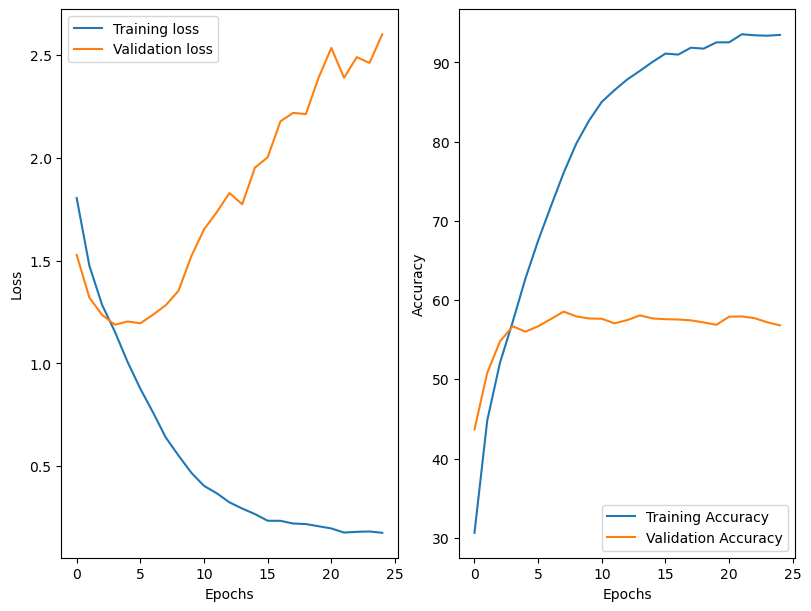

In [274]:
fig, V7 = plt.subplots(1, 2, figsize=(8, 6), layout='constrained')

V7[0].plot(range(num_epochs_25), train_loss, label='Training loss')
V7[0].plot(range(num_epochs_25), valid_loss, label='Validation loss')
V7[0].set_xlabel('Epochs')
V7[0].set_ylabel('Loss')
V7[0].legend() 
V7[1].plot(range(num_epochs_25), train_acc, label='Training Accuracy');
V7[1].plot(range(num_epochs_25), valid_acc, label='Validation Accuracy');
V7[1].set_xlabel('Epochs')
V7[1].set_ylabel('Accuracy')
V7[1].legend()
fig.savefig('V7_Dropout_Linear_Layer_with_Normalization_Weight_decay.png')

What if learning rate scheduling helped?

# Model 8
setup learning rate scheduler

In [66]:
def train_model_scheduling(
    model, 
    num_epochs, 
    optimizer, 
    criterion, 
    train_loader, 
    valid_loader
):

    # Set device to GPU if available, otherwise use CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Arrays to track metrics per epoch
    train_loss_per_epoch = []
    valid_loss_per_epoch = []
    train_acc_per_epoch = []
    valid_acc_per_epoch = []
    
    train_start = timer()

    # Training loop
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        train_loss = 0.0
        correct_train, total_train = 0, 0

        for batch_images, batch_labels in train_loader:
            # Move images and labels to device (GPU or CPU)
            batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs_train = model(batch_images)
            _, predicted_train = torch.max(outputs_train, 1)
            total_train += batch_labels.size(0)
            correct_train += (predicted_train == batch_labels).sum().item()

            # Compute and accumulate loss
            loss = criterion(outputs_train, batch_labels)
            train_loss += loss.item()

            # Backward pass and optimizer step
            loss.backward()
            optimizer.step()

        valid_loss = 0.0
        correct_valid, total_valid = 0, 0
        model.eval()

        # Validation loop
        with torch.inference_mode():
            for batch_images, batch_labels in valid_loader:
                batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)

                # Forward pass
                outputs_valid = model(batch_images)
                _, predicted_valid = torch.max(outputs_valid, 1)
                total_valid += batch_labels.size(0)
                correct_valid += (predicted_valid == batch_labels).sum().item()

                # Compute and accumulate loss
                loss = criterion(outputs_valid, batch_labels)
                valid_loss += loss.item()
    
        scheduler.step()

        
        # Compute average losses and accuracies
        train_loss /= len(train_loader)
        valid_loss /= len(valid_loader)
        train_accuracy = 100 * correct_train / total_train
        valid_accuracy = 100 * correct_valid / total_valid

        # Append metrics for this epoch
        train_loss_per_epoch.append(train_loss)
        valid_loss_per_epoch.append(valid_loss)
        train_acc_per_epoch.append(train_accuracy)
        valid_acc_per_epoch.append(valid_accuracy)

        # Print epoch stats
        print(
            f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, "
            f"Train Accuracy: {train_accuracy:.2f}% | Valid Loss: {valid_loss:.4f}, "
            f"Valid Accuracy: {valid_accuracy:.2f}%"
        )

    train_end = timer()
    print(f"Training completed in {train_end - train_start:.2f} seconds on {device}.")

    return train_loss_per_epoch, valid_loss_per_epoch, train_acc_per_epoch, valid_acc_per_epoch

In [68]:
torch.manual_seed(42)
modelV8 = CNN_Dropout_Linear(num_classes=num_classes)

# Use Cross-Entropy Loss for classification
criterion = nn.CrossEntropyLoss()

# Only decay of weights, not bias
decay = []
no_decay = []
for name, param in modelV8.named_parameters():
    if "bias" in name:
        no_decay.append(param)
    else:
        decay.append(param)
# Adam optimizer
optimizer = optim.Adam([
    {"params": decay, "weight_decay": 1e-4},
    {"params": no_decay, "weight_decay": 0.0},
], lr=lr)

scheduler = StepLR(optimizer, step_size=8, gamma=0.1) # every 8 epochs, divide lr by 10

NameError: name 'CNN_Dropout_Linear' is not defined

In [287]:
train_loss = []
valid_loss = []
train_acc = []
valid_acc = []

train_loss, valid_loss, train_acc, valid_acc = train_model_scheduling(modelV8, num_epochs_25, optimizer, criterion, train_loader, valid_loader) # Execution Time: 926 seconds

Epoch [1/25], Train Loss: 1.8242, Train Accuracy: 29.78% | Valid Loss: 1.5481, Valid Accuracy: 41.99%
Epoch [2/25], Train Loss: 1.5215, Train Accuracy: 42.66% | Valid Loss: 1.3614, Valid Accuracy: 49.17%
Epoch [3/25], Train Loss: 1.3425, Train Accuracy: 49.97% | Valid Loss: 1.2634, Valid Accuracy: 52.53%
Epoch [4/25], Train Loss: 1.2168, Train Accuracy: 54.85% | Valid Loss: 1.2076, Valid Accuracy: 55.42%
Epoch [5/25], Train Loss: 1.0910, Train Accuracy: 59.36% | Valid Loss: 1.1734, Valid Accuracy: 56.07%
Epoch [6/25], Train Loss: 0.9845, Train Accuracy: 63.28% | Valid Loss: 1.1836, Valid Accuracy: 56.01%
Epoch [7/25], Train Loss: 0.8870, Train Accuracy: 66.69% | Valid Loss: 1.2154, Valid Accuracy: 58.45%
Epoch [8/25], Train Loss: 0.7840, Train Accuracy: 70.76% | Valid Loss: 1.2040, Valid Accuracy: 58.18%
Epoch [9/25], Train Loss: 0.6008, Train Accuracy: 77.77% | Valid Loss: 1.2436, Valid Accuracy: 59.53%
Epoch [10/25], Train Loss: 0.5457, Train Accuracy: 79.49% | Valid Loss: 1.2641, Va

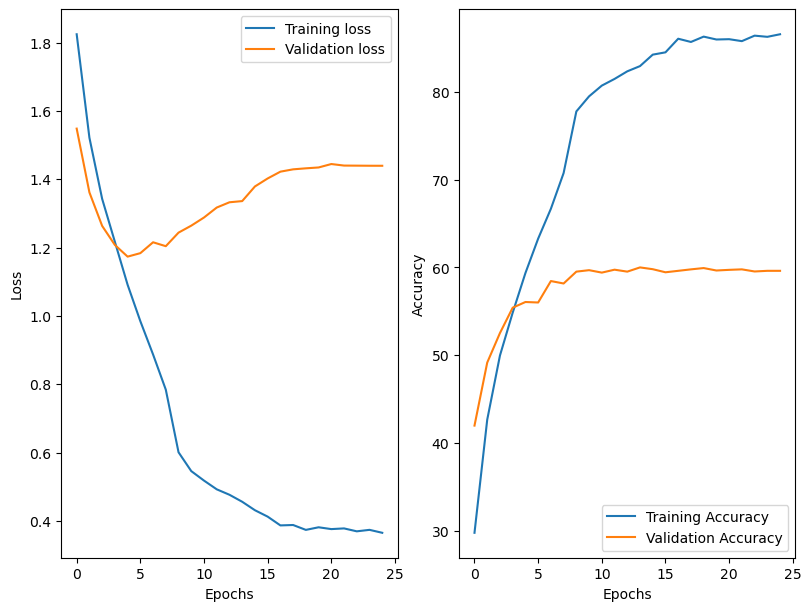

In [290]:
fig, V8 = plt.subplots(1, 2, figsize=(8, 6), layout='constrained')

V8[0].plot(range(num_epochs_25), train_loss, label='Training loss')
V8[0].plot(range(num_epochs_25), valid_loss, label='Validation loss')
V8[0].set_xlabel('Epochs')
V8[0].set_ylabel('Loss')
V8[0].legend() 
V8[1].plot(range(num_epochs_25), train_acc, label='Training Accuracy');
V8[1].plot(range(num_epochs_25), valid_acc, label='Validation Accuracy');
V8[1].set_xlabel('Epochs')
V8[1].set_ylabel('Accuracy')
V8[1].legend()
fig.savefig('V8_Dropout_Linear_Layer_with_Normalization_Weight_decay_LR_Scheduling.png')

Lowers slightly validation loss, validation overfitting remains

Try adding extra conv

# Neural Network #4
### Will try adding an extra Convolutional Layer to increase feature extraction capabilites and will reduce inner channels of Linear Layers (256-->128)

In [31]:
# Reduce Linear parameters (256-->128)
class CNN_4(nn.Module):
    def __init__(self, num_classes):  # Modify num_classes based on your dataset
        super(CNN_4, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)

        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Fully connected layers
        self.fc1 = nn.Linear(256 * 6 * 6, 128)  # 128 feature maps of size 12x12
        self.fc2 = nn.Linear(128, num_classes)  # Final layer outputs 'num_classes'

        # Dropout layer
        self.dropout = nn.Dropout(p=0.5) # Dropout of 30% ( Only between convolutional layers)

    def forward(self, x):
        # Pass through conv layers + ReLU + pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))

        # Flatten the output for fully connected layers
        x = x.view(-1, 256 * 6 * 6)

        # Fully connected layers (with dropout)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x


# Model 9
Uses the new Neural network model with 4 convolutional layers

In [52]:
torch.manual_seed(42)
modelV9 = CNN_4(num_classes=num_classes)

# Use Cross-Entropy Loss for classification
criterion = nn.CrossEntropyLoss()

# Only decay of weights, not bias
decay = []
no_decay = []
for name, param in modelV9.named_parameters():
    if "bias" in name:
        no_decay.append(param)
    else:
        decay.append(param)
# Adam optimizer
optimizer = optim.Adam([
    {"params": decay, "weight_decay": 1e-4},
    {"params": no_decay, "weight_decay": 0.0},
], lr=lr)

scheduler = StepLR(optimizer, step_size=8, gamma=0.1) # every 8 epochs, divide lr by 10

In [53]:
train_loss = []
valid_loss = []
train_acc = []
valid_acc = []

train_loss, valid_loss, train_acc, valid_acc = train_model_scheduling(modelV9, num_epochs_25, optimizer, criterion, train_loader, valid_loader) # Execution Time: 944 seconds

Epoch [1/25], Train Loss: 1.9497, Train Accuracy: 24.09% | Valid Loss: 1.7031, Valid Accuracy: 36.50%
Epoch [2/25], Train Loss: 1.6499, Train Accuracy: 37.17% | Valid Loss: 1.4873, Valid Accuracy: 44.58%
Epoch [3/25], Train Loss: 1.5199, Train Accuracy: 41.49% | Valid Loss: 1.3582, Valid Accuracy: 48.89%
Epoch [4/25], Train Loss: 1.4342, Train Accuracy: 45.56% | Valid Loss: 1.3432, Valid Accuracy: 49.59%
Epoch [5/25], Train Loss: 1.3599, Train Accuracy: 47.89% | Valid Loss: 1.2667, Valid Accuracy: 51.74%
Epoch [6/25], Train Loss: 1.3054, Train Accuracy: 50.44% | Valid Loss: 1.2363, Valid Accuracy: 54.66%
Epoch [7/25], Train Loss: 1.2450, Train Accuracy: 52.34% | Valid Loss: 1.2189, Valid Accuracy: 55.16%
Epoch [8/25], Train Loss: 1.2008, Train Accuracy: 54.01% | Valid Loss: 1.2574, Valid Accuracy: 52.76%
Epoch [9/25], Train Loss: 1.0865, Train Accuracy: 57.94% | Valid Loss: 1.1561, Valid Accuracy: 57.73%
Epoch [10/25], Train Loss: 1.0447, Train Accuracy: 59.32% | Valid Loss: 1.1564, Va

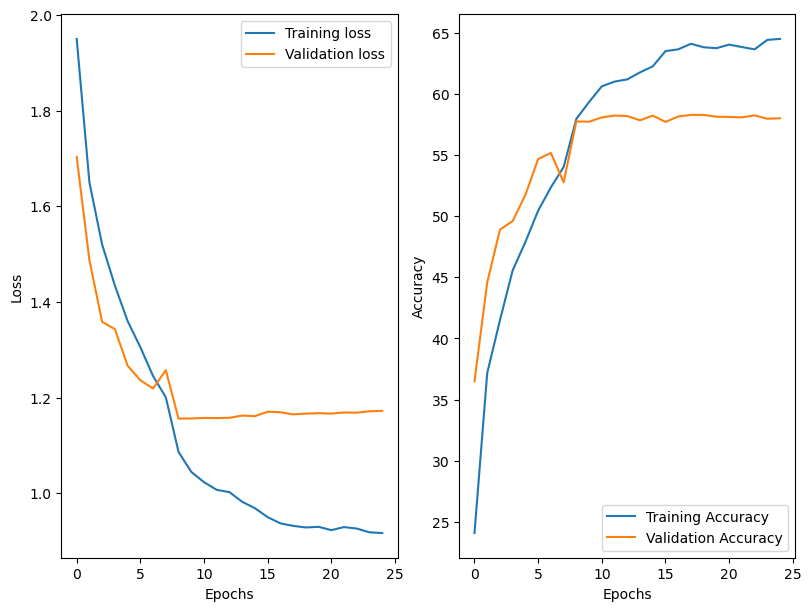

In [63]:
fig, V9 = plt.subplots(1, 2, figsize=(8, 6), layout='constrained')

V9[0].plot(range(num_epochs_25), train_loss, label='Training loss')
V9[0].plot(range(num_epochs_25), valid_loss, label='Validation loss')
V9[0].set_xlabel('Epochs')
V9[0].set_ylabel('Loss')
V9[0].legend() 
V9[1].plot(range(num_epochs_25), train_acc, label='Training Accuracy');
V9[1].plot(range(num_epochs_25), valid_acc, label='Validation Accuracy');
V9[1].set_xlabel('Epochs')
V9[1].set_ylabel('Accuracy')
V9[1].legend()
fig.savefig('V9_Dropout_Linear_Layer_with_Normalization_Weight_decay_LR_Scheduling_4Convs.png')

Ok! validation loss is consistently below 1.2 for epochs>5, also it seems like the network has stopped overfitting to the validation data, maybe more convolutional layers are needed.

In [75]:
test_model(modelV9, criterion, test_loader)

Test Loss: 1.1664, Test Accuracy: 58.84%


# Model 10
Could try without weight decay

In [87]:
torch.manual_seed(42)
modelV10 = CNN_4(num_classes=num_classes)

# Use Cross-Entropy Loss for classification
criterion = nn.CrossEntropyLoss()

# Adam optimizer
optimizer = optim.Adam(modelV10.parameters(), lr=lr)

scheduler = StepLR(optimizer, step_size=8, gamma=0.1) # every 8 epochs, divide lr by 10

In [89]:
train_loss = []
valid_loss = []
train_acc = []
valid_acc = []

train_loss, valid_loss, train_acc, valid_acc = train_model_scheduling(modelV10, num_epochs_25, optimizer, criterion, train_loader, valid_loader) # Execution Time: 809 seconds

Epoch [1/25], Train Loss: 1.9161, Train Accuracy: 25.62% | Valid Loss: 1.7051, Valid Accuracy: 37.81%
Epoch [2/25], Train Loss: 1.6007, Train Accuracy: 39.28% | Valid Loss: 1.4427, Valid Accuracy: 45.93%
Epoch [3/25], Train Loss: 1.4629, Train Accuracy: 44.04% | Valid Loss: 1.3155, Valid Accuracy: 50.91%
Epoch [4/25], Train Loss: 1.3629, Train Accuracy: 48.38% | Valid Loss: 1.2642, Valid Accuracy: 53.72%
Epoch [5/25], Train Loss: 1.2798, Train Accuracy: 51.80% | Valid Loss: 1.2242, Valid Accuracy: 53.79%
Epoch [6/25], Train Loss: 1.1942, Train Accuracy: 54.60% | Valid Loss: 1.1823, Valid Accuracy: 56.60%
Epoch [7/25], Train Loss: 1.1184, Train Accuracy: 57.61% | Valid Loss: 1.1577, Valid Accuracy: 57.14%
Epoch [8/25], Train Loss: 1.0421, Train Accuracy: 60.31% | Valid Loss: 1.1487, Valid Accuracy: 57.34%
Epoch [9/25], Train Loss: 0.8768, Train Accuracy: 66.68% | Valid Loss: 1.1157, Valid Accuracy: 59.34%
Epoch [10/25], Train Loss: 0.8236, Train Accuracy: 68.41% | Valid Loss: 1.1269, Va

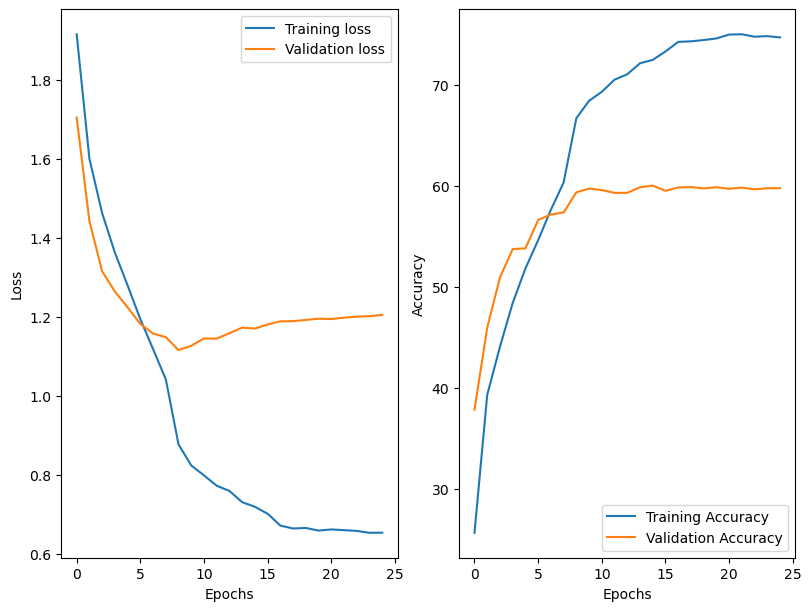

In [91]:
fig, V10 = plt.subplots(1, 2, figsize=(8, 6), layout='constrained')

V10[0].plot(range(num_epochs_25), train_loss, label='Training loss')
V10[0].plot(range(num_epochs_25), valid_loss, label='Validation loss')
V10[0].set_xlabel('Epochs')
V10[0].set_ylabel('Loss')
V10[0].legend() 
V10[1].plot(range(num_epochs_25), train_acc, label='Training Accuracy');
V10[1].plot(range(num_epochs_25), valid_acc, label='Validation Accuracy');
V10[1].set_xlabel('Epochs')
V10[1].set_ylabel('Accuracy')
V10[1].legend()
fig.savefig('V10_4Convs_no_weight_decay.png')

In [93]:
test_model(modelV10, criterion, test_loader)

Test Loss: 1.2175, Test Accuracy: 60.58%


This is the best model so far

# Model 11
AdamW optimizer

In [48]:
torch.manual_seed(42)
modelV11 = CNN_4(num_classes=num_classes)

# Use Cross-Entropy Loss for classification
criterion = nn.CrossEntropyLoss()

# Only decay of weights, not bias
decay = []
no_decay = []
for name, param in modelV11.named_parameters():
    if "bias" in name:
        no_decay.append(param)
    else:
        decay.append(param)
# Adam optimizer
optimizer = optim.AdamW([
    {"params": decay, "weight_decay": 1e-4},
    {"params": no_decay, "weight_decay": 0.0},
], lr=lr)

scheduler = StepLR(optimizer, step_size=8, gamma=0.1) # every 8 epochs, divide lr by 10

In [50]:
train_loss = []
valid_loss = []
train_acc = []
valid_acc = []

train_loss, valid_loss, train_acc, valid_acc = train_model_scheduling(modelV11, num_epochs_25, optimizer, criterion, train_loader, valid_loader) # Execution Time: 892 seconds

Epoch [1/25], Train Loss: 1.9192, Train Accuracy: 25.46% | Valid Loss: 1.6812, Valid Accuracy: 37.46%
Epoch [2/25], Train Loss: 1.6249, Train Accuracy: 38.41% | Valid Loss: 1.4590, Valid Accuracy: 44.67%
Epoch [3/25], Train Loss: 1.4885, Train Accuracy: 43.44% | Valid Loss: 1.3409, Valid Accuracy: 49.93%
Epoch [4/25], Train Loss: 1.3901, Train Accuracy: 46.92% | Valid Loss: 1.2983, Valid Accuracy: 51.22%
Epoch [5/25], Train Loss: 1.3146, Train Accuracy: 50.21% | Valid Loss: 1.2570, Valid Accuracy: 52.46%
Epoch [6/25], Train Loss: 1.2302, Train Accuracy: 53.42% | Valid Loss: 1.2102, Valid Accuracy: 54.50%
Epoch [7/25], Train Loss: 1.1602, Train Accuracy: 55.74% | Valid Loss: 1.2078, Valid Accuracy: 54.22%
Epoch [8/25], Train Loss: 1.0840, Train Accuracy: 58.77% | Valid Loss: 1.1830, Valid Accuracy: 56.12%
Epoch [9/25], Train Loss: 0.9359, Train Accuracy: 64.31% | Valid Loss: 1.1690, Valid Accuracy: 57.88%
Epoch [10/25], Train Loss: 0.8951, Train Accuracy: 65.60% | Valid Loss: 1.1785, Va

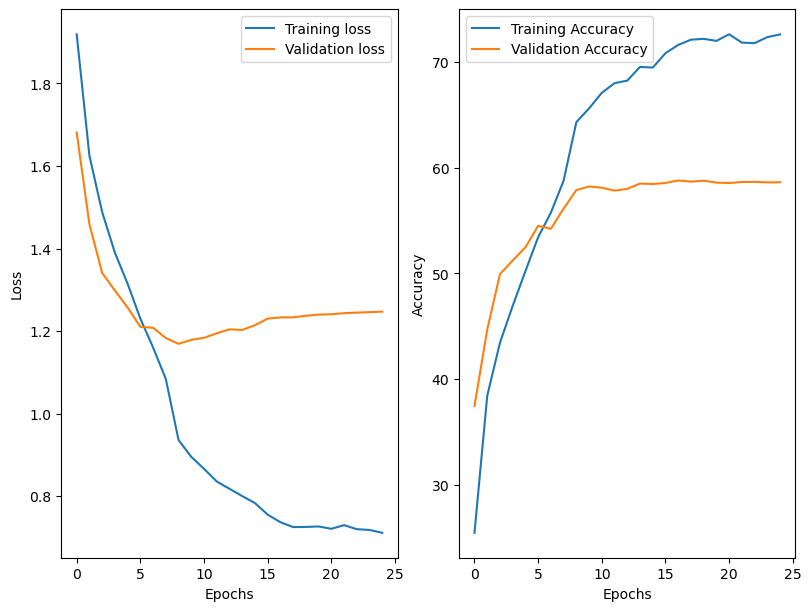

In [51]:
fig, V11 = plt.subplots(1, 2, figsize=(8, 6), layout='constrained')

V11[0].plot(range(num_epochs_25), train_loss, label='Training loss')
V11[0].plot(range(num_epochs_25), valid_loss, label='Validation loss')
V11[0].set_xlabel('Epochs')
V11[0].set_ylabel('Loss')
V11[0].legend() 
V11[1].plot(range(num_epochs_25), train_acc, label='Training Accuracy');
V11[1].plot(range(num_epochs_25), valid_acc, label='Validation Accuracy');
V11[1].set_xlabel('Epochs')
V11[1].set_ylabel('Accuracy')
V11[1].legend()
fig.savefig('V11_4Convs_AdamW.png')

# Model 12
weight decay = 5 * 10^-4, learning rate scheduling with lr_initial = 0.001

In [70]:
torch.manual_seed(42)
modelV12 = CNN_4(num_classes=num_classes)

# Use Cross-Entropy Loss for classification
criterion = nn.CrossEntropyLoss()

# Only decay of weights, not bias
decay = []
no_decay = []
for name, param in modelV12.named_parameters():
    if "bias" in name:
        no_decay.append(param)
    else:
        decay.append(param)
        
# Adam optimizer
optimizer = optim.Adam([
    {"params": decay, "weight_decay": 1e-4},
    {"params": no_decay, "weight_decay": 0.0},
], lr=lr)

scheduler = StepLR(optimizer, step_size=8, gamma=0.1) # every 8 epochs, divide lr by 10

In [72]:
train_loss = []
valid_loss = []
train_acc = []
valid_acc = []

train_loss, valid_loss, train_acc, valid_acc = train_model_scheduling(modelV12, num_epochs_25, optimizer, criterion, train_loader, valid_loader) # Execution Time: 944 seconds

Epoch [1/25], Train Loss: 1.9538, Train Accuracy: 23.89% | Valid Loss: 1.7162, Valid Accuracy: 36.70%
Epoch [2/25], Train Loss: 1.6648, Train Accuracy: 36.75% | Valid Loss: 1.4914, Valid Accuracy: 42.80%
Epoch [3/25], Train Loss: 1.5363, Train Accuracy: 41.40% | Valid Loss: 1.3812, Valid Accuracy: 47.69%
Epoch [4/25], Train Loss: 1.4498, Train Accuracy: 44.44% | Valid Loss: 1.3161, Valid Accuracy: 50.96%
Epoch [5/25], Train Loss: 1.3742, Train Accuracy: 47.42% | Valid Loss: 1.2856, Valid Accuracy: 51.81%
Epoch [6/25], Train Loss: 1.3046, Train Accuracy: 49.83% | Valid Loss: 1.2469, Valid Accuracy: 54.22%
Epoch [7/25], Train Loss: 1.2446, Train Accuracy: 52.42% | Valid Loss: 1.2215, Valid Accuracy: 53.29%
Epoch [8/25], Train Loss: 1.1828, Train Accuracy: 54.28% | Valid Loss: 1.2071, Valid Accuracy: 54.29%
Epoch [9/25], Train Loss: 1.0647, Train Accuracy: 58.78% | Valid Loss: 1.1415, Valid Accuracy: 57.86%
Epoch [10/25], Train Loss: 1.0320, Train Accuracy: 60.04% | Valid Loss: 1.1375, Va

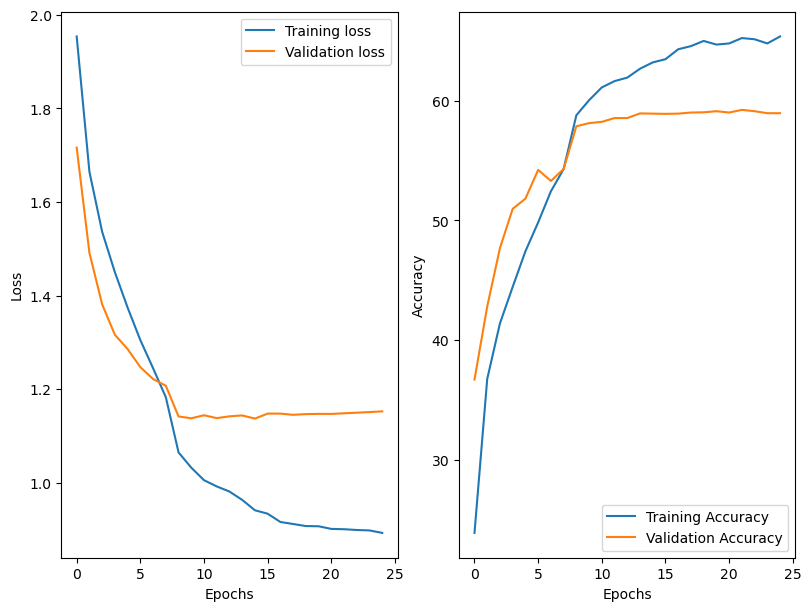

In [73]:
fig, V12 = plt.subplots(1, 2, figsize=(8, 6), layout='constrained')

V12[0].plot(range(num_epochs_25), train_loss, label='Training loss')
V12[0].plot(range(num_epochs_25), valid_loss, label='Validation loss')
V12[0].set_xlabel('Epochs')
V12[0].set_ylabel('Loss')
V12[0].legend() 
V12[1].plot(range(num_epochs_25), train_acc, label='Training Accuracy');
V12[1].plot(range(num_epochs_25), valid_acc, label='Validation Accuracy');
V12[1].set_xlabel('Epochs')
V12[1].set_ylabel('Accuracy')
V12[1].legend()
fig.savefig('V12_Dropout_Full_Layer_with_Normalization_Weight_decay_LR_Scheduling_4Convs.png')

# Optimal Hyperparameter search
Will try to try several combinations of lr, weight decay to find optimals

In [ ]:
# Sample hyperparameter values
learning_rates = [1e-3, 5e-3, 1e-2]
weight_decays = [1e-5, 1e-4, 1e-3]

# Placeholder for results
results = []

# Iterate over hyperparameters
for lr in learning_rates:
    for wd in weight_decays:
        # Define model 
        model = CNN_4(num_classes=num_classes) 
        
        # Define optimizer with current hyperparams
        # Only decay of weights, not bias
        decay = []
        no_decay = []
        for name, param in model.named_parameters():
            if "bias" in name:
                no_decay.append(param)
            else:
                decay.append(param)
                
        # Adam optimizer
        optimizer = optim.Adam([
            {"params": decay, "weight_decay": wd},
            {"params": no_decay, "weight_decay": 0.0},
        ], lr=lr)
        
        scheduler = StepLR(optimizer, step_size=8, gamma=0.1) # every 10 epochs, divide lr by 10
        print(f"lr = {lr}, weight decay = {wd}")
        print("--------------------------------")
        # Train model and compute validation accuracy (pseudo-code)
        train_model(model, num_epochs_25, optimizer, criterion, train_loader, valid_loader)  # Replace with actual function
        
        # Store results
        results.append((lr, wd, train_acc, val_acc))
    print("-----------------------------------------------------------------------------")

Based on the above, optimal weight decay is between 10**-3 and 10**-4. Learning rate scheduling generally outperforms constant lr, but initial values of lr not greater than 0.001 should be selected

Something is wrong with the implementation, after some loops it stops training models?

# Testing Dataset accuracy

In [33]:
# Initial Preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to PyTorch Tensor, scales [0,255] to [0,1]
    transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)) # Normalize data to [-1,1]
])

# Create dataset objects
test_dataset= CustomDataset(test_image_paths, test_class_labels, transform=transform)

# DataLoader for batching
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Implement early stopping
model stops training after certain steps of no progress

In [36]:
def train_model_earlystop(
    model, 
    num_epochs, 
    optimizer, 
    criterion, 
    train_loader, 
    valid_loader
):

    # Set device to GPU if available, otherwise use CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    
    train_start = timer()

    # Training loop
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        train_loss = 0.0
        correct_train, total_train = 0, 0

        for batch_images, batch_labels in train_loader:
            # Move images and labels to device (GPU or CPU)
            batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs_train = model(batch_images)
            _, predicted_train = torch.max(outputs_train, 1)
            total_train += batch_labels.size(0)
            correct_train += (predicted_train == batch_labels).sum().item()

            # Compute and accumulate loss
            loss = criterion(outputs_train, batch_labels)
            train_loss += loss.item()

            # Backward pass and optimizer step
            loss.backward()
            optimizer.step()

        valid_loss = 0.0
        correct_valid, total_valid = 0, 0
        model.eval()

        # Validation loop
        with torch.inference_mode():
            for batch_images, batch_labels in valid_loader:
                batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)

                # Forward pass
                outputs_valid = model(batch_images)
                _, predicted_valid = torch.max(outputs_valid, 1)
                total_valid += batch_labels.size(0)
                correct_valid += (predicted_valid == batch_labels).sum().item()

                # Compute and accumulate loss
                loss = criterion(outputs_valid, batch_labels)
                valid_loss += loss.item()
    
        scheduler.step()

        
        # Compute average losses and accuracies
        train_loss /= len(train_loader)
        valid_loss /= len(valid_loader)
        train_accuracy = 100 * correct_train / total_train
        valid_accuracy = 100 * correct_valid / total_valid

        # Print epoch stats
        print(
            f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, "
            f"Train Accuracy: {train_accuracy:.2f}% | Valid Loss: {valid_loss:.4f}, "
            f"Valid Accuracy: {valid_accuracy:.2f}%"
        )

        # Check early stopping
        early_stopping(valid_accuracy)
        if early_stopping.early_stop:
            print("Early stopping triggered!")
            break

    train_end = timer()
    print(f"Training completed in {train_end - train_start:.2f} seconds on {device}.")

# Apply early stopping to best models and graph Confusion Matrix

In [39]:
def test_model_with_confusion_matrix(model, criterion, test_loader, class_names):
    """
    Test the model, compute per-label accuracies, and display a confusion matrix.

    Args:
    - model: Trained model to evaluate.
    - criterion: Loss function.
    - test_loader: DataLoader for test dataset.
    - class_names: List of class names corresponding to labels.

    Returns:
    - None
    """

    # Set device to GPU if available, otherwise use CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    test_loss = 0.0
    correct_test, total_test = 0, 0

    all_preds = []
    all_labels = []

    model.eval()
    with torch.inference_mode():
        for batch_images, batch_labels in test_loader:
            batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)

            # Forward pass
            outputs_test = model(batch_images)
            _, predicted_test = torch.max(outputs_test, 1)
            
            total_test += batch_labels.size(0)
            correct_test += (predicted_test == batch_labels).sum().item()

            # Save predictions and labels for confusion matrix
            all_preds.extend(predicted_test.cpu().numpy())
            all_labels.extend(batch_labels.cpu().numpy())

            # Compute and accumulate loss
            loss = criterion(outputs_test, batch_labels)
            test_loss += loss.item()

    # Compute average test loss and accuracy
    test_loss /= len(test_loader)
    test_accuracy = 100 * correct_test / total_test

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    # Print overall test stats
    print(
        f"Test Loss: {test_loss:.4f}, "
        f"Test Accuracy: {test_accuracy:.2f}%"
    )

    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(10, 8))
    disp.plot(cmap="Blues", ax=ax, xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.show()


## Model 10

In [42]:
torch.manual_seed(42)
modelV10 = CNN_4(num_classes=num_classes)

# Use Cross-Entropy Loss for classification
criterion = nn.CrossEntropyLoss()

# Adam optimizer
optimizer = optim.Adam(modelV10.parameters(), lr=lr)

scheduler = StepLR(optimizer, step_size=8, gamma=0.1) # every 8 epochs, divide lr by 10

# Early stopping instance
early_stopping = EarlyStopping(patience=4)

In [44]:
train_model_earlystop(modelV10, num_epochs_25, optimizer, criterion, train_loader, valid_loader) # Execution Time: 710 seconds

Epoch [1/25], Train Loss: 1.9213, Train Accuracy: 25.50% | Valid Loss: 1.6946, Valid Accuracy: 36.96%
Epoch [2/25], Train Loss: 1.6126, Train Accuracy: 38.56% | Valid Loss: 1.4378, Valid Accuracy: 46.28%
Epoch [3/25], Train Loss: 1.4721, Train Accuracy: 43.62% | Valid Loss: 1.3270, Valid Accuracy: 50.74%
Epoch [4/25], Train Loss: 1.3770, Train Accuracy: 48.23% | Valid Loss: 1.2729, Valid Accuracy: 53.37%
Epoch [5/25], Train Loss: 1.2987, Train Accuracy: 50.91% | Valid Loss: 1.2372, Valid Accuracy: 53.46%
Epoch [6/25], Train Loss: 1.2101, Train Accuracy: 53.72% | Valid Loss: 1.1834, Valid Accuracy: 55.83%
Epoch [7/25], Train Loss: 1.1296, Train Accuracy: 57.22% | Valid Loss: 1.1530, Valid Accuracy: 57.34%
Epoch [8/25], Train Loss: 1.0619, Train Accuracy: 59.63% | Valid Loss: 1.1645, Valid Accuracy: 56.16%
Epoch [9/25], Train Loss: 0.9093, Train Accuracy: 65.28% | Valid Loss: 1.1341, Valid Accuracy: 58.68%
Epoch [10/25], Train Loss: 0.8584, Train Accuracy: 67.56% | Valid Loss: 1.1293, Va

Test Loss: 1.2353, Test Accuracy: 59.82%


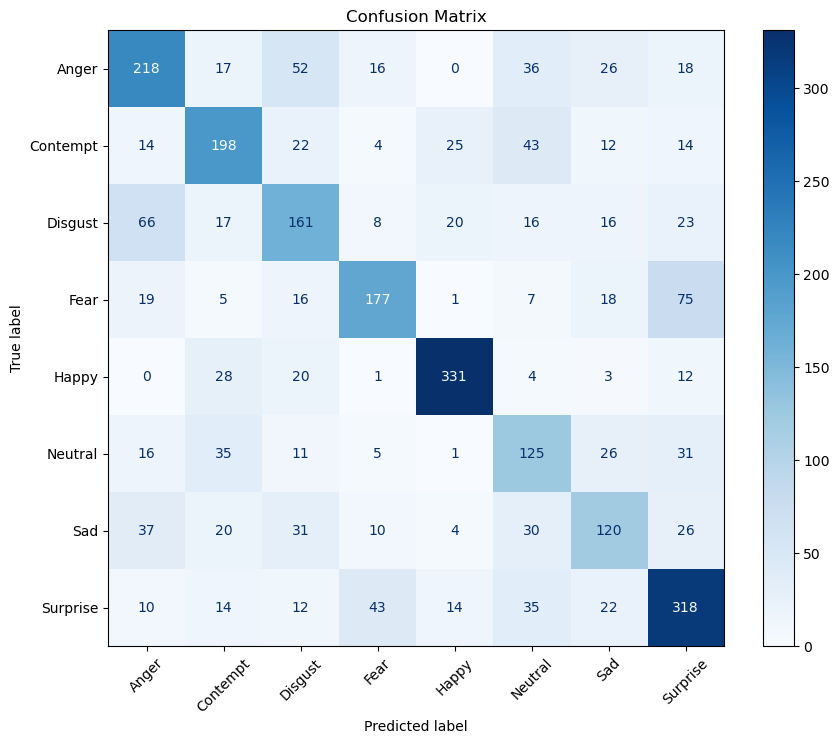

In [46]:
test_model_with_confusion_matrix(modelV10, criterion, test_loader, class_names)

## Model 12

In [153]:
torch.manual_seed(42)
modelV12 = CNN_4(num_classes=num_classes)

# Use Cross-Entropy Loss for classification
criterion = nn.CrossEntropyLoss()

# Only decay of weights, not bias
decay = []
no_decay = []
for name, param in modelV12.named_parameters():
    if "bias" in name:
        no_decay.append(param)
    else:
        decay.append(param)
        
# Adam optimizer
optimizer = optim.Adam([
    {"params": decay, "weight_decay": 1e-4},
    {"params": no_decay, "weight_decay": 0.0},
], lr=lr)

scheduler = StepLR(optimizer, step_size=8, gamma=0.1) # every 8 epochs, divide lr by 10

# Early stopping instance
early_stopping = EarlyStopping(patience=3)

In [155]:
train_model_earlystop(modelV12, num_epochs_25, optimizer, criterion, train_loader, valid_loader) # Execution Time: 586 seconds

Epoch [1/25], Train Loss: 1.9510, Train Accuracy: 23.83% | Valid Loss: 1.7152, Valid Accuracy: 35.79%
Epoch [2/25], Train Loss: 1.6482, Train Accuracy: 37.16% | Valid Loss: 1.4684, Valid Accuracy: 43.38%
Epoch [3/25], Train Loss: 1.4981, Train Accuracy: 42.59% | Valid Loss: 1.3550, Valid Accuracy: 49.32%
Epoch [4/25], Train Loss: 1.4044, Train Accuracy: 46.69% | Valid Loss: 1.3172, Valid Accuracy: 50.78%
Epoch [5/25], Train Loss: 1.3269, Train Accuracy: 49.96% | Valid Loss: 1.2302, Valid Accuracy: 53.55%
Epoch [6/25], Train Loss: 1.2558, Train Accuracy: 52.25% | Valid Loss: 1.1995, Valid Accuracy: 55.85%
Epoch [7/25], Train Loss: 1.1891, Train Accuracy: 54.75% | Valid Loss: 1.1961, Valid Accuracy: 55.51%
Epoch [8/25], Train Loss: 1.1351, Train Accuracy: 56.73% | Valid Loss: 1.1669, Valid Accuracy: 57.33%
Epoch [9/25], Train Loss: 1.0015, Train Accuracy: 61.62% | Valid Loss: 1.1322, Valid Accuracy: 58.99%
Epoch [10/25], Train Loss: 0.9649, Train Accuracy: 62.86% | Valid Loss: 1.1310, Va

Test Loss: 1.2028, Test Accuracy: 60.00%


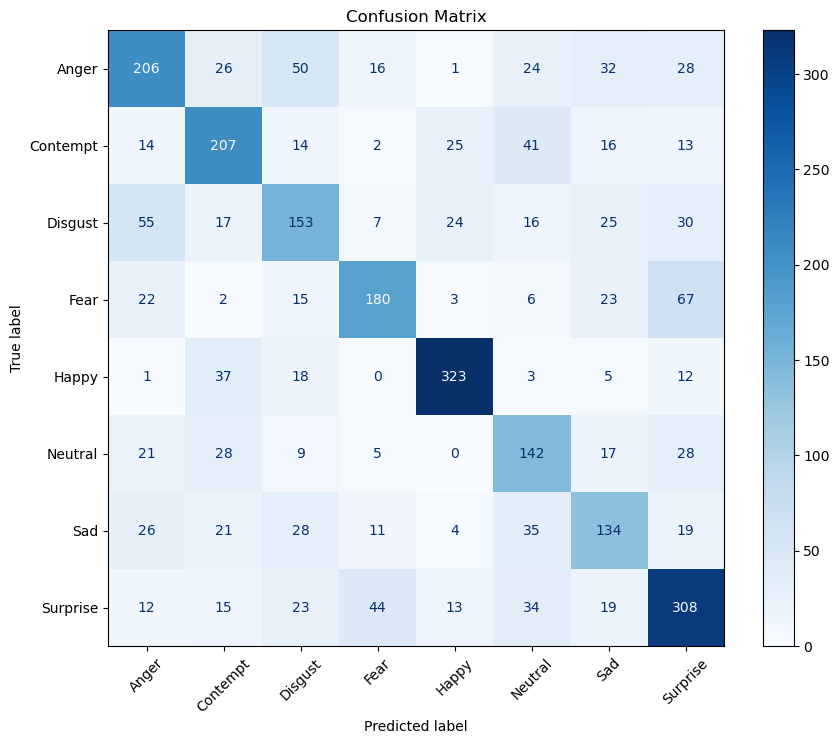

In [202]:
test_model_with_confusion_matrix(modelV12, criterion, test_loader, class_names)